In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

['house-prices-advanced-regression-techniques']


#### Load Data

In [110]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
print("Loaded")

Loaded


In [111]:
print("Train:", train.shape[0], "rows", train.shape[1],"features")
print("Test:",test.shape[0], "rows", test.shape[1],"features")

Train: 1460 rows 81 features
Test: 1459 rows 80 features


In [112]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [113]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Since the IDs are unique, we can just drop them.

In [114]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

There is a skew to SalePrice so it should be transformed with a log transformation.

<AxesSubplot: title={'center': 'Log Normal'}, xlabel='SalePrice'>

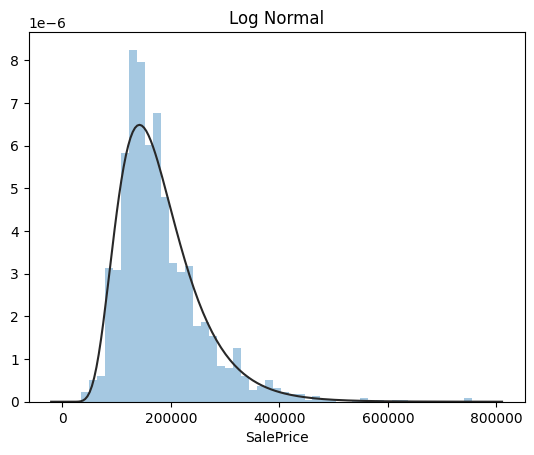

In [115]:
plt.title('Log Normal')
sns.distplot(train['SalePrice'], kde=False, fit=stats.lognorm)

In [116]:
train['SalePrice'] = np.log1p(train['SalePrice'])

Heatmap to see the correlation between each feature and the target

<AxesSubplot: >

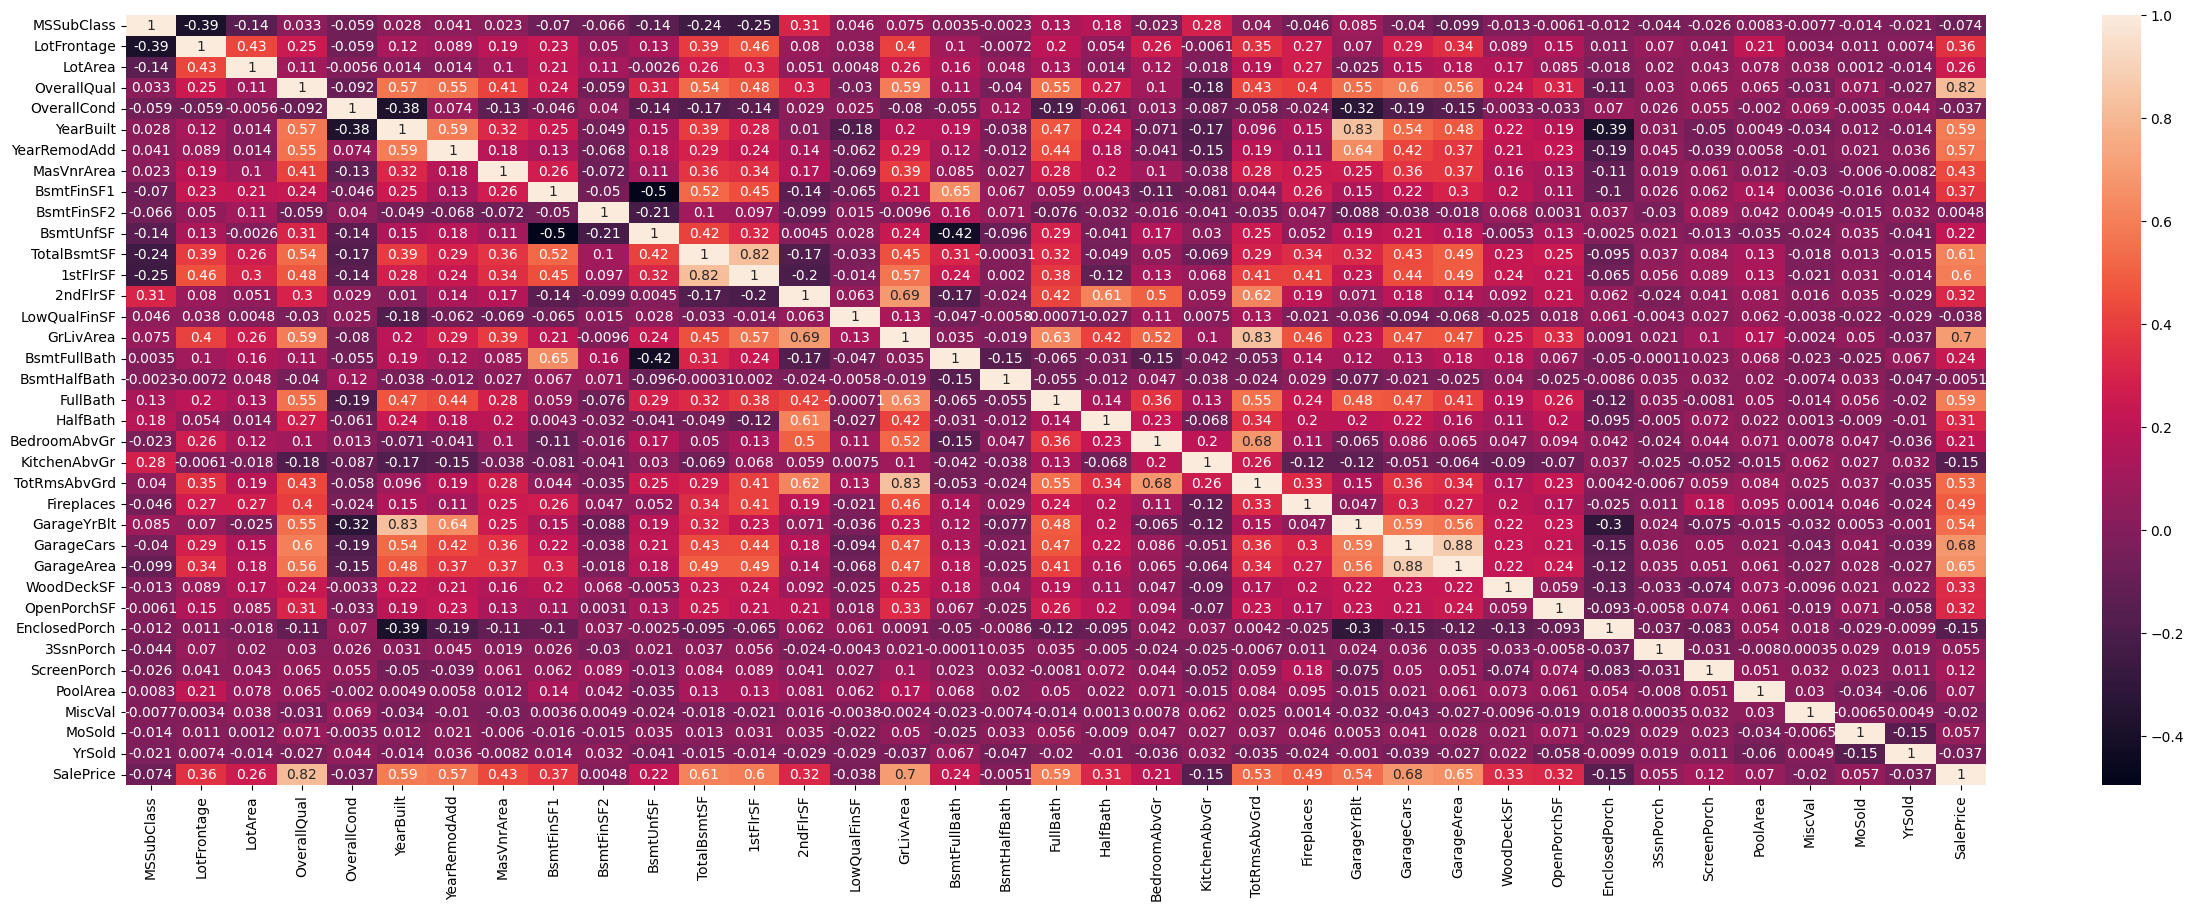

In [117]:
plt.figure(figsize = (30,10))
sns.heatmap(train.corr(),annot=True)

Next, concat the train and test together for easier feature engineering. y will be the SalePrice in the train data.

In [118]:
y = train.SalePrice.reset_index(drop = True)
train_f = train.drop(['SalePrice'], axis = 1)
test_f = test

In [119]:
df = pd.concat([train_f, test_f]).reset_index(drop = True)
print(df.shape)

(2919, 79)


## Data Analysis and Preprocessing

Start by looking at numbers of quantitative and categorical features.

In [120]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
categorical = [f for f in df.columns if df.dtypes[f] == 'object']

In [121]:
quantitative

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [122]:
len(quantitative)

36

In [123]:
categorical

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [124]:
len(categorical)

43

<AxesSubplot: >

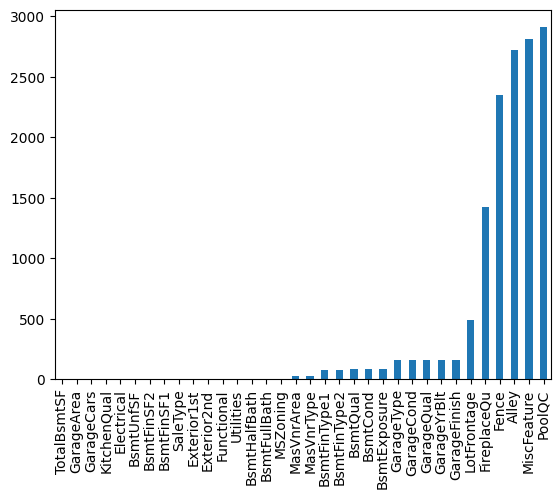

In [125]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals > 0]
missing_vals.sort_values(inplace=True)
missing_vals.plot.bar()

In [126]:
len(missing_vals)

34

#### Dealing with Missing Values
There are 34 features with missing values, with 4 having more than 50% of its values missing. Those values will be dropped, while others will either be replaced with mean/mode or NA and 0 values.

Looking through the features, certain numeric features like YrSold and MSSubClass seems to be Quantitative but should be treated as Qualitative. We shall covert them to strings

In [127]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].apply(str)
df['MoSold'] = df['MoSold'].apply(str)

In [128]:
df.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1 ,inplace=True)

In [129]:
df['Functional'].value_counts()
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])

In [130]:
#fill the rest of the categorical values in the same way
df['Electrical']  = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['SaleType']    = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])


<AxesSubplot: >

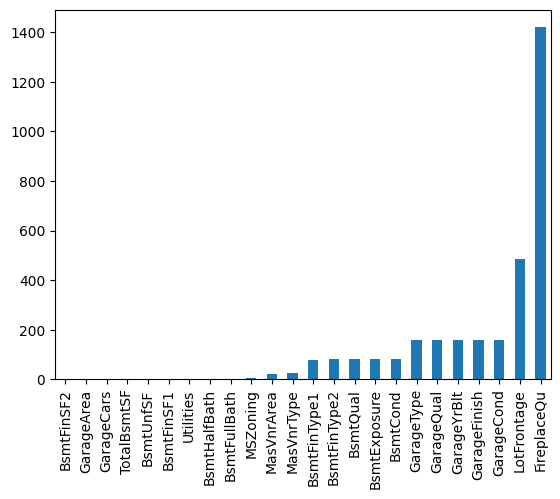

In [131]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals > 0]
missing_vals.sort_values(inplace=True)
missing_vals.plot.bar()

Most of the remaining missing categorical values could be missing due to not having a certain feature. We can see in the graph that the 5 Garage features have the same amount of missing values. Similarly basement features seems to have the same amount of missing values too. Lets replace the missing values with None and 0. 

In [132]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col] = df[col].fillna('None')
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df[col] = df[col].fillna(0)

<AxesSubplot: >

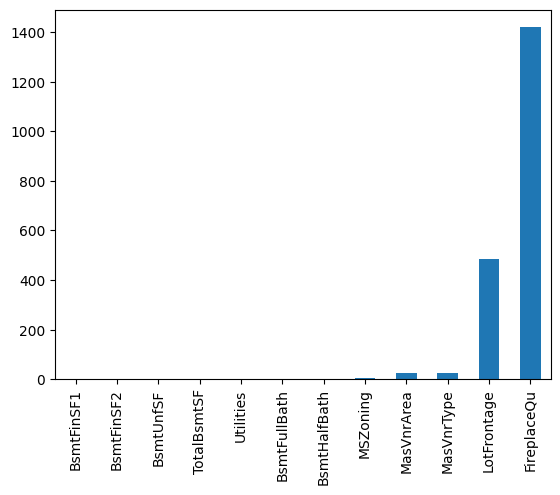

In [133]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals > 0]
missing_vals.sort_values(inplace=True)
missing_vals.plot.bar()

The LotFrontage and MSZoning features are interesting as they can be related to Neighborhood and MSSubClass features

In [134]:
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Just fill up the rest of the missing values.

In [135]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
categorical = [f for f in df.columns if df.dtypes[f] == 'object']
df.update(df[categorical].fillna('None'))
df.update(df[quantitative].fillna(0))

In [136]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals > 0]
missing_vals

Series([], dtype: int64)

#### Additional feature engineering 
In real life, big factors of house prices are usually the size of the house and the number of rooms. As such, we can make features like TotalSF which will take in total Square Footage of the house for better predictions.

In [137]:
SF_features = [col for col in df.columns if 'SF' in col]
SF_features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [138]:
Bathrooms_feature = [col for col in df.columns if 'Bath' in col]
Bathrooms_feature
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

In [139]:
df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

<AxesSubplot: xlabel='TotalSF', ylabel='SalePrice'>

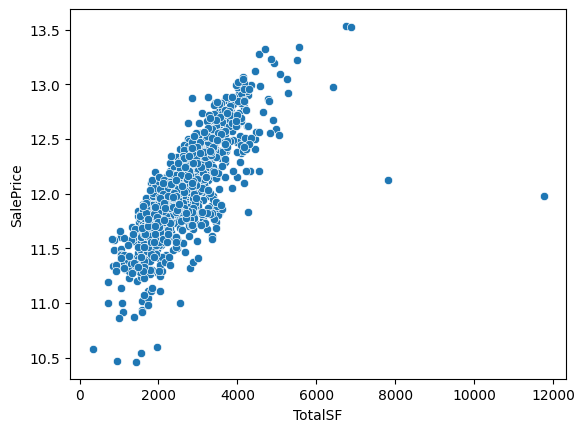

In [140]:
sns.scatterplot(x = df['TotalSF'], y= y)

<AxesSubplot: xlabel='Total_Bathrooms', ylabel='SalePrice'>

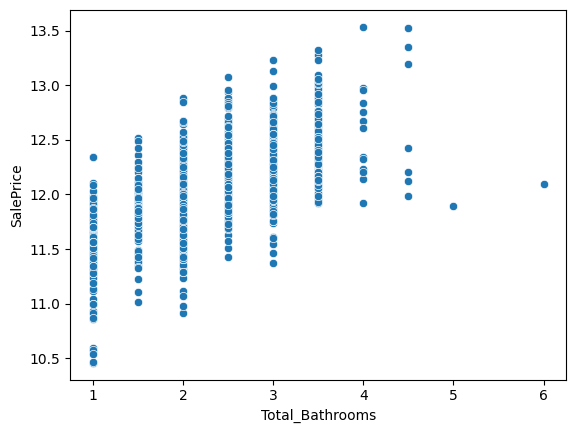

In [141]:
sns.scatterplot(x = df['Total_Bathrooms'], y= y)

Add more simple features like having pool, having a second floor, having a garage, a basement and having a fireplace.

In [142]:
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
print(df.shape)

(2919, 83)


Now we do a OHE over the features 

In [143]:
final_df = pd.get_dummies(df).reset_index(drop=True)
print(final_df.shape)

(2919, 324)


Split into X and test X

In [144]:
X = final_df.iloc[:len(y),:]
X_sub = final_df.iloc[len(X):, :]

Now to prevent overfitting drop columns with over 99.94% of zeros 

In [145]:
overfit = []
for i in X.columns:
    count = X[i].value_counts()
    num_zeros = count.iloc[0]
    if num_zeros / len(X) * 100 > 99.94:
        overfit.append(i)
overfit = list(overfit)
overfit.append('MSZoning_C (all)')
X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape)

X (1460, 321) y (1460,)


## Model

Define kfold cross verification for testing reasons.

In [146]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=0)

Define loss function as well as a cross validation scoring function for the model

In [147]:
#root mean squared error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

In [148]:
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)

Using XGBRegressor as the model

In [149]:
model = XGBRegressor()
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [150]:
score = cv_rmse(model)

In [151]:
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1386 (0.0225)



In [152]:
# ypred = model.predict(X_sub)
# ypred = np.floor(np.expm1(ypred))

# pred = pd.DataFrame(ypred)
# sub_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
# submissions = pd.concat([sub_df['Id'],pred],axis=1)
# submissions.columns = ['Id','SalePrice']
# submissions.to_csv('submission.csv',index=False)

This unoptimized XGBoost model have a RMSE of 0.13764

## Hyper Parameter Tuning

Randomized Search CV will be used to optimize the XGBoost model.

In [153]:
from sklearn.model_selection import RandomizedSearchCV
Tuned_model = XGBRegressor()

In [154]:
base_score = [0.25,0.5,0.75,1]
n_est = [100,500,750,1000,1250]
max_depth = [2,3,5,10,15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.2]
min_child_weight=[1,2,3,4]

grid={
    'n_estimators':n_est,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
}

In [155]:
random_cv = RandomizedSearchCV(estimator=Tuned_model,
                               param_distributions=grid,
                               cv=5, n_iter=50,
                               scoring = 'neg_mean_absolute_error', n_jobs=4,
                               verbose = 5,
                               return_train_score = True,
                               random_state=1)

In [156]:
#random_cv.fit(X,y)

In [157]:
#random_cv.best_estimator_

The following parameters are found to give the best RMSE score.

In [158]:
model = XGBRegressor(base_score=0.75,booster='gbtree',learning_rate=0.05,max_depth=3,min_child_weight=1,n_estimators=500)
model.fit(X,y)

XGBRegressor(base_score=0.75, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [159]:
ypred = model.predict(X_sub)
ypred = np.floor(np.expm1(ypred))

pred = pd.DataFrame(ypred)
sub_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
submissions = pd.concat([sub_df['Id'],pred],axis=1)
submissions.columns = ['Id','SalePrice']
submissions.to_csv('submission.csv',index=False)

Optimized model submission score: 0.12928 
  
  Non-optimized submission model: 0.13764

# Next Steps
- Removing outliers, finding more relations with the data
  
  Further work will be looking into outliers in the data and removing them. 
  
  Clustering techniques can also be applied to the data for better results.
- Blend models
  
  Through looking at top solutions of the competitions, I've notices that participants use a blend of models to predict the SalePrice. Models like Stack_gen, Elasticnet, Lasso, Ridge, Svr etc will require further looking into.